# Assignment 3 Timeseries

## Different kinds of timeseries tasks

## A Temperature-forecasting example

In [38]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 08:28:47--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.192.136, 52.217.88.94, 52.216.42.72, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.192.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  19.2MB/s    in 0.7s    

2024-04-07 08:28:48 (19.2 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Inspecting the data of the Jena weather dataset**

In [39]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [40]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

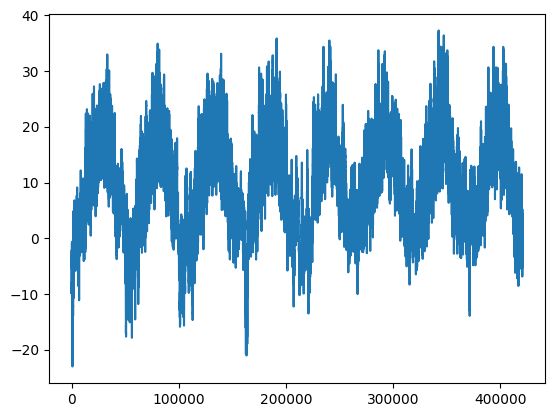

In [41]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

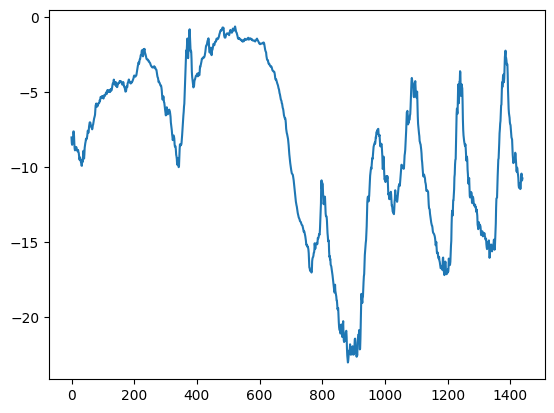

In [42]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [43]:
training_samples = int(0.5 * len(raw_data))
validation_samples = int(0.25 * len(raw_data))
test_samples = len(raw_data) - training_samples - validation_samples
print("training_samples:", training_samples)
print("validation_samples:", validation_samples)
print("test_samples:", test_samples)

training_samples: 210225
validation_samples: 105112
test_samples: 105114


### Preparing the data

**Normalizing the data**

In [44]:
mean = raw_data[:training_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:training_samples].std(axis=0)
raw_data /= std

In [45]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [46]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=training_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=training_samples,
    end_index=training_samples + validation_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=training_samples + validation_samples)

**Inspecting the output of one of our datasets**

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 9s 9ms/step - loss: 12.7001 - mae: 2.7539 - val_loss: 12.9983 - val_mae: 2.8524
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 9.0349 - mae: 2.3707 - val_loss: 10.1007 - val_mae: 2.4983
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.3217 - mae: 2.2770 - val_loss: 10.2301 - val_mae: 2.5222
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 7.8623 - mae: 2.2138 - val_loss: 10.9187 - val_mae: 2.6115
Epoch 5/10
819/819 [==============================] - 7s 9ms/step - loss: 7.5392 - mae: 2.1704 - val_loss: 12.0034 - val_mae: 2.7411
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 7.2872 - mae: 2.1334 - val_loss: 10.3549 - val_mae: 2.5353
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 7.1065 - mae: 2.1086 - val_loss: 11.0631 - val_mae: 2.6380
Epoch 8/10
819/819 [==============================] - 7s 9ms/step - 

**Plotting results**

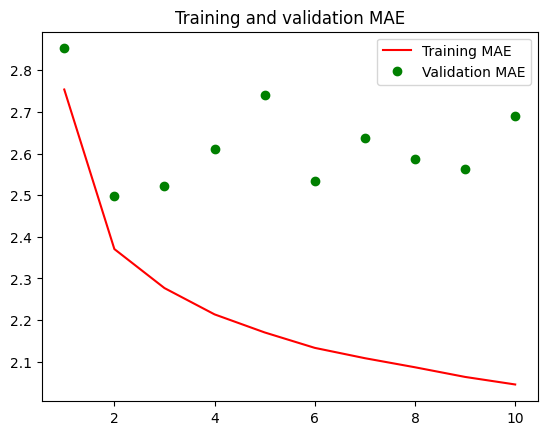

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training MAE")
plt.plot(epochs, val_loss, "go", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/15
819/819 [==============================] - 11s 10ms/step - loss: 20.4621 - mae: 3.5631 - val_loss: 15.7383 - val_mae: 3.1691
Epoch 2/15
819/819 [==============================] - 7s 9ms/step - loss: 15.1230 - mae: 3.0822 - val_loss: 14.8456 - val_mae: 3.0409
Epoch 3/15
819/819 [==============================] - 7s 9ms/step - loss: 13.8126 - mae: 2.9409 - val_loss: 15.1658 - val_mae: 3.0752
Epoch 4/15
819/819 [==============================] - 8s 9ms/step - loss: 12.8691 - mae: 2.8346 - val_loss: 14.2148 - val_mae: 2.9828
Epoch 5/15
819/819 [==============================] - 7s 9ms/step - loss: 12.2819 - mae: 2.7701 - val_loss: 14.2297 - val_mae: 2.9954
Epoch 6/15
819/819 [==============================] - 7s 9ms/step - loss: 11.7992 - mae: 2.7146 - val_loss: 18.6830 - val_mae: 3.4396
Epoch 7/15
819/819 [==============================] - 7s 9ms/step - loss: 11.4137 - mae: 2.6672 - val_loss: 16.8597 - val_mae: 3.2808
Epoch 8/15
819/819 [==============================] - 8s 9ms

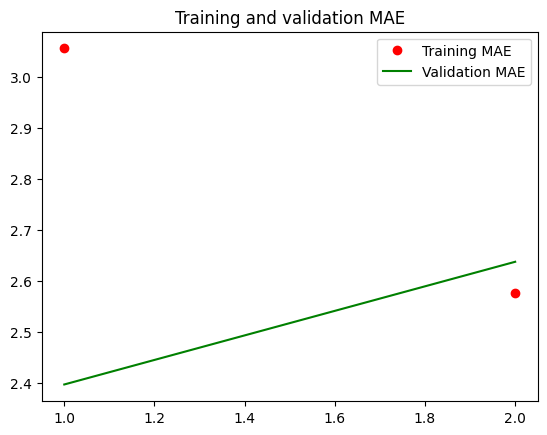

In [47]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### A first recurrent baseline

**A simple LSTM-based model with Dense 16**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 13ms/step - loss: 41.9390 - mae: 4.7152 - val_loss: 12.8420 - val_mae: 2.7439
Epoch 2/10
819/819 [==============================] - 10s 13ms/step - loss: 10.9786 - mae: 2.5737 - val_loss: 10.7405 - val_mae: 2.5067
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 9.6935 - mae: 2.4275 - val_loss: 9.6340 - val_mae: 2.4061
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 9.2946 - mae: 2.3747 - val_loss: 10.2843 - val_mae: 2.4474
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 9.0645 - mae: 2.3436 - val_loss: 9.6910 - val_mae: 2.4156
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 8.8409 - mae: 2.3124 - val_loss: 9.8919 - val_mae: 2.4308
Epoch 7/10
819/819 [==============================] - 10s 13ms/step - loss: 8.6448 - mae: 2.2834 - val_loss: 10.0604 - val_mae: 2.4584
Epoch 8/10
819/819 [==============================] - 11

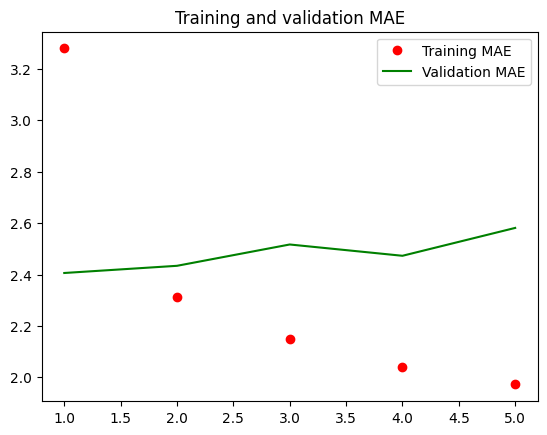

In [27]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**A simple LSTM-based model with Dense 40**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(40)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 13s 13ms/step - loss: 20.9425 - mae: 3.2791 - val_loss: 9.5574 - val_mae: 2.4059
Epoch 2/5
819/819 [==============================] - 10s 12ms/step - loss: 8.8423 - mae: 2.3141 - val_loss: 9.7996 - val_mae: 2.4338
Epoch 3/5
819/819 [==============================] - 10s 12ms/step - loss: 7.6533 - mae: 2.1507 - val_loss: 10.4250 - val_mae: 2.5167
Epoch 4/5
819/819 [==============================] - 10s 12ms/step - loss: 6.8984 - mae: 2.0405 - val_loss: 10.0510 - val_mae: 2.4728
Epoch 5/5
405/405 [==============================] - 3s 6ms/step - loss: 10.4665 - mae: 2.5511
Test MAE: 2.55


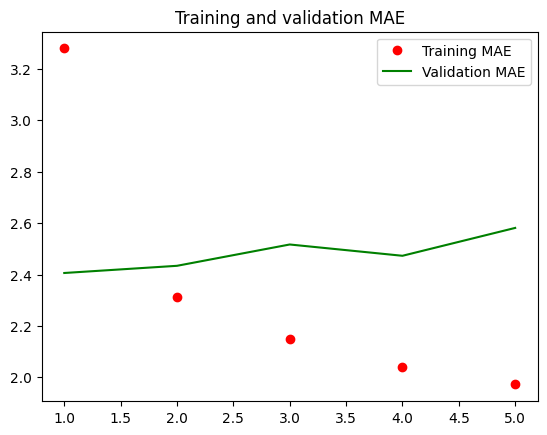

In [28]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**A simple LSTM-based model with Dense 80**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(80)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 12s 13ms/step - loss: 13.1097 - mae: 2.6909 - val_loss: 9.6402 - val_mae: 2.4239
Epoch 2/5
819/819 [==============================] - 10s 12ms/step - loss: 6.6008 - mae: 1.9972 - val_loss: 11.9014 - val_mae: 2.6911
Epoch 3/5
819/819 [==============================] - 10s 12ms/step - loss: 4.8147 - mae: 1.6963 - val_loss: 12.6985 - val_mae: 2.7702
Epoch 4/5
819/819 [==============================] - 10s 12ms/step - loss: 3.7547 - mae: 1.4898 - val_loss: 13.2708 - val_mae: 2.8456
Epoch 5/5
405/405 [==============================] - 3s 6ms/step - loss: 10.8085 - mae: 2.5817
Test MAE: 2.58


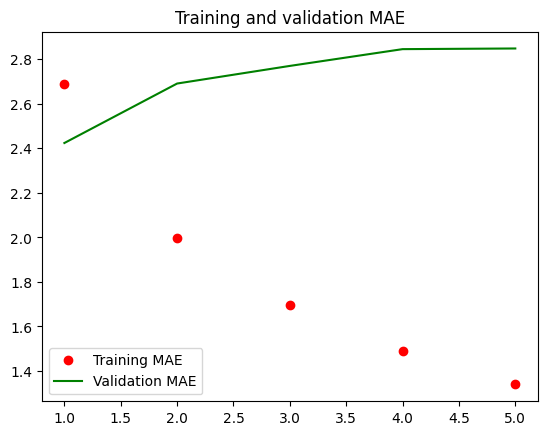

In [30]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [31]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [32]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [33]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [34]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [35]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a combination of 1d_Convnet and dropout-regularized LSTM**

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(32, 5, activation="relu", padding="same")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 121s 144ms/step - loss: 16.2489 - mae: 3.0565 - val_loss: 9.5592 - val_mae: 2.3963
Epoch 2/2
819/819 [==============================] - 117s 143ms/step - loss: 10.9912 - mae: 2.5762 - val_loss: 11.2854 - val_mae: 2.6374


405/405 [==============================] - 10s 25ms/step - loss: 11.2350 - mae: 2.6729
Test MAE: 2.67


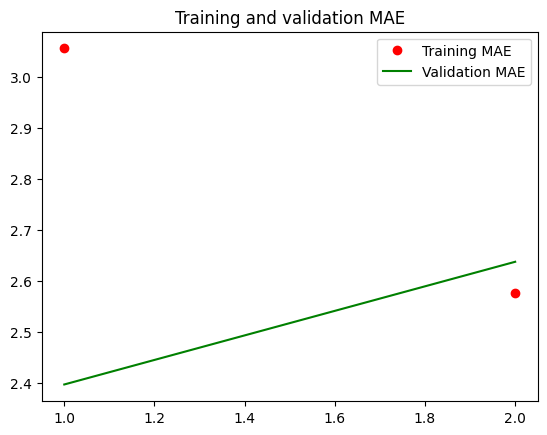

In [48]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [30]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked LSTM model**

In [49]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 421s 508ms/step - loss: 24.9626 - mae: 3.7019 - val_loss: 10.3211 - val_mae: 2.4851
Epoch 2/2
819/819 [==============================] - 417s 509ms/step - loss: 13.7447 - mae: 2.8757 - val_loss: 10.1540 - val_mae: 2.4532


405/405 [==============================] - 33s 80ms/step - loss: 11.4504 - mae: 2.6366
Test MAE: 2.64


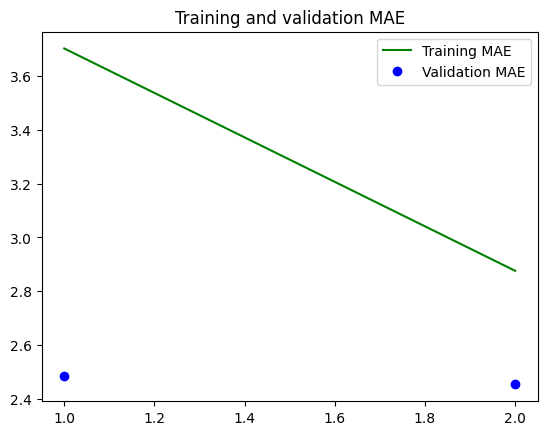

In [52]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "g", label="Training MAE")
plt.plot(epochs, val_loss, "bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [53]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16,recurrent_dropout=0.25))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)

Epoch 1/2
819/819 [==============================] - 383s 462ms/step - loss: 26.2037 - mae: 3.7119 - val_loss: 10.7512 - val_mae: 2.5277
Epoch 2/2
819/819 [==============================] - 377s 460ms/step - loss: 9.6658 - mae: 2.4222 - val_loss: 9.6891 - val_mae: 2.4101


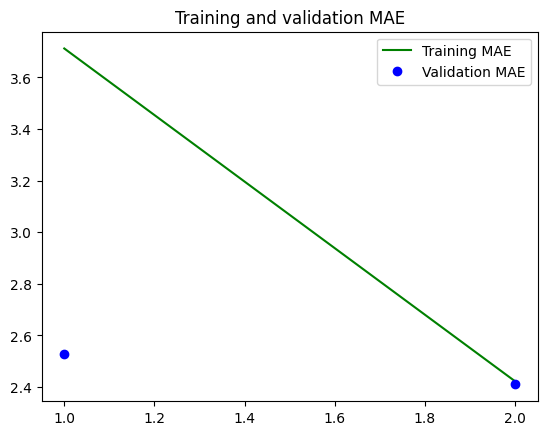

In [55]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "g", label="Training MAE")
plt.plot(epochs, val_loss, "bo", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Going even further

## Summary